<h1>Kuvailu: Northwind-tietokanta</h1>

Suuntaa antava relaatiomalli:

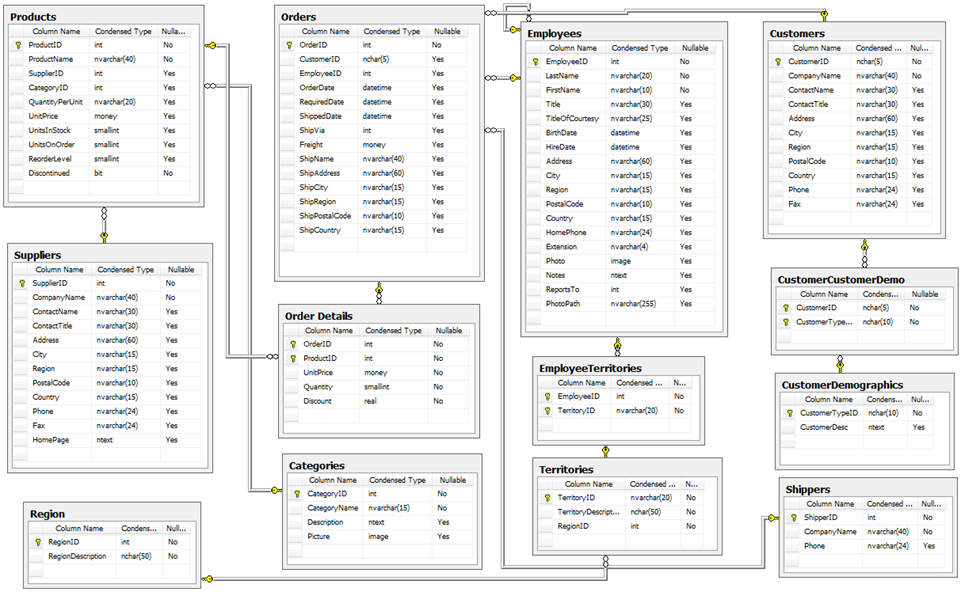

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

In [2]:
conn = sqlite3.connect('Northwind_large.sqlite')
cur = conn.cursor()

In [3]:
# Tietokannan taulut
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cur.fetchall())

[('Employees',), ('Categories',), ('Customers',), ('Shippers',), ('Suppliers',), ('Orders',), ('Products',), ('OrderDetails',), ('CustomerCustomerDemo',), ('CustomerDemographics',), ('Region',), ('Territories',), ('EmployeeTerritories',)]


In [4]:
# Haetaan SQL-kyselyllä kaikki tilaukset dataframeen
df = pd.read_sql_query("""SELECT o.OrderDate, od.OrderId, round(sum(od.UnitPrice*od.Quantity*(1-od.Discount)), 2) AS Total,
                                cu.CompanyName AS Customer, o.ShipCountry, o.ShipRegion, s.CompanyName AS Shipper,
                                e.LastName AS Salesperson
                            FROM OrderDetails od, Orders o, Employees e, Customers cu, Shippers s
                            WHERE o.Id=od.OrderId
                                AND e.Id=o.EmployeeID
                                AND cu.Id=o.CustomerId
                                AND o.ShipVia=s.Id
                            GROUP BY od.OrderId""", conn)
df.shape

(16789, 8)

In [5]:
# Aikaleimat indeksiin, pudotetaan tarpeettomaksi käynyt sarake pois, järjestetään indeksi aikajärjestykseen
df.index = pd.to_datetime(df['OrderDate'])
df = df.drop('OrderDate', axis=1)
df.sort_index(inplace=True)

df.head()

,OrderId,Total,Customer,ShipCountry,ShipRegion,Shipper,Salesperson
OrderDate,,,,,,,
2012-07-04,10248,440.00,Vins et alcools Chevalier,France,Western Europe,Federal Shipping,Buchanan
2012-07-05,10249,1863.40,Toms Spezialitäten,Germany,Western Europe,Speedy Express,Suyama
2012-07-08,10250,1552.60,Hanari Carnes,Brazil,South America,United Package,Peacock
2012-07-08,10251,654.06,Victuailles en stock,France,Western Europe,Speedy Express,Leverling
2012-07-09,10252,3597.90,Suprêmes délices,Belgium,Western Europe,United Package,Peacock


In [6]:
df.tail()

,OrderId,Total,Customer,ShipCountry,ShipRegion,Shipper,Salesperson
OrderDate,,,,,,,
2016-02-19 17:40:22,21912,16156.36,Suprêmes délices,USA,North America,Speedy Express,Davolio
2016-02-19 21:24:30,24197,34624.52,Piccolo und mehr,UK,British Isles,Federal Shipping,Peacock
2016-02-19 22:25:48,20009,26644.10,Königlich Essen,France,Western Europe,Speedy Express,Fuller
2016-02-19 22:28:36,12876,10371.45,Vins et alcools Chevalier,USA,North America,Federal Shipping,King
2016-02-19 22:36:39,23272,46075.57,Folies gourmandes,Mexico,Central America,United Package,Callahan


In [7]:
# Puuttuuko havaintoja?
df.isnull().sum()

OrderId        0
Total          0
Customer       0
ShipCountry    0
ShipRegion     0
Shipper        0
Salesperson    0
dtype: int64

In [8]:
# Tilauksen loppusumman lukumäärä, keskiarvo, keskihajonta, pienin, alaneljännes, mediaani, yläneljännes ja suurin
df[['Total']].describe().style.format('{:.2f}')

,Total
count,16789.00
mean,27269.59
std,17559.14
min,7.75
25%,11864.20
50%,26648.06
75%,41689.87
max,73223.19


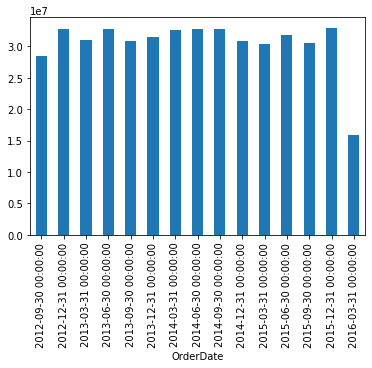

In [9]:
# Paljonko olivat myyntitulot vuosineljänneksittäin?
df['Total'].resample('Q').sum().plot(kind='bar')

In [10]:
# Mihin maihin lähetettiin tilauksia ja paljonko myyntitulot olivat?
df.pivot_table(values='Total', index='ShipCountry',
               aggfunc=sum).sort_values(by='Total',
                ascending=False).style.format('{:.0f}')

,Total
ShipCountry,
USA,65557755
Germany,63345553
France,49424061
Brazil,44609031
UK,37068659
Mexico,25728089
Venezuela,21603082
Spain,19267219
Argentina,15614469


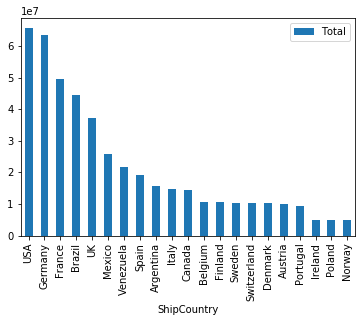

In [11]:
# Edellinen havainnollisemmin
df.pivot_table(values='Total', index='ShipCountry',
               aggfunc=sum).sort_values(by='Total',
                ascending=False).plot(kind='bar')

In [12]:
# Miten myyjien myynnit jakaantuivat ja paljonko myyntitulot olivat alueittain vuonna 2015?
df['2015'].pivot_table(values='Total', columns='ShipRegion',
                      index='Salesperson', aggfunc=sum).style.format('{:.0f}')

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe
Salesperson,,,,,,,,,
Buchanan,1140139,777821,87747,2580443,911757,375717,2783018,781339,4217372
Callahan,1452592,647614,65154,2561733,441240,310492,2559595,1072740,3997767
Davolio,1363071,812916,292521,2056418,683548,587754,2606509,1143172,4362188
Dodsworth,1161943,889162,151539,1991106,573354,471887,2741282,928782,4875433
Fuller,1091760,986251,138551,2650126,460450,364876,3240379,1199142,4080271
King,1507273,911735,141710,2184592,798335,804845,2291608,1393939,4893079
Leverling,1267842,643008,41788,2162851,590249,631910,2984044,1690656,3972434
Peacock,1030521,694773,104165,2666401,655336,463104,2678378,1075086,4518509
Suyama,1333980,1066896,186342,2689972,731933,248140,2531446,1448415,3901694


In [13]:
# Miten tilaukset jakaantuivat eri rahtaajille myyjittäin?
(pd.crosstab(df['Salesperson'], df['Shipper'],
             normalize='index')*100).style.format('{:.1f} %')

Shipper,Federal Shipping,Speedy Express,United Package
Salesperson,,,
Buchanan,33.8 %,34.2 %,32.0 %
Callahan,33.5 %,29.9 %,36.6 %
Davolio,33.3 %,33.9 %,32.8 %
Dodsworth,33.4 %,34.2 %,32.5 %
Fuller,31.6 %,33.8 %,34.6 %
King,34.9 %,31.7 %,33.4 %
Leverling,35.3 %,33.6 %,31.1 %
Peacock,34.1 %,32.4 %,33.5 %
Suyama,33.0 %,34.3 %,32.7 %


(9.0, 0.0)

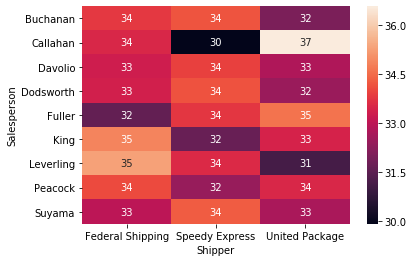

In [14]:
# Edellinen havainnollisemmin
import seaborn as sns
sns.heatmap(data=(pd.crosstab(df['Salesperson'], df['Shipper'],
                              normalize='index')*100), annot=True)

# Korjataan bugi matplotlib'n versiossa 3.1.1
# https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

In [15]:
# Kuinka paljon myyjät antoivat alennusta?

# Haetaan SQL-kyselyllä annetut alennukset myyjittäin dataframeen
df2 = pd.read_sql_query("""SELECT e.LastName AS Salesperson, round(sum(od.UnitPrice*od.Quantity*od.Discount), 2) AS Discount
                        FROM OrderDetails od, Orders o, Employees e
                        WHERE o.Id=od.OrderId AND e.Id=o.EmployeeID
                        GROUP BY e.LastName
                        ORDER BY 2 DESC""", conn)
df2.index = df2['Salesperson']
df2 = df2.drop('Salesperson', axis=1)
df2

,Discount
Salesperson,
Peacock,17296.60
King,16727.76
Fuller,11211.51
Leverling,10238.46
Davolio,10036.11
Buchanan,6775.47
Callahan,6438.75
Dodsworth,5655.93
Suyama,4284.97


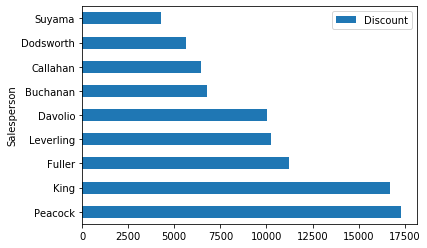

In [16]:
# Havainnollistetaan edellinen pylväskuviona
df2.plot.barh()

In [17]:
# Mitkä olivat kolme myydyintä tuotetta rahamääräisesti kussakin tuotekategoriassa vuonna 2016?

# Haetaan SQL-kyselyllä tuotekategorioiden kolme parhaiten myynyttä tuotetta dataframeen
df3 = pd.DataFrame() # Määritetään tyhjä df3
cat = pd.read_sql_query("SELECT * FROM Categories", conn) # Selvitetään, mitä tuotekategorioita on olemassa
# Haetaan SQL-kyselyllä kolme myydyintä tuotetta jokaisesta kategoriasta for-silmukan avulla
for x in cat['CategoryName'].values.tolist(): # Muunnetaan kategoriat dataframesta listaksi
    sql =   ("""SELECT ca.CategoryName AS Category, p.ProductName AS Product,
                    round(sum(od.UnitPrice*od.Quantity*(1-od.Discount)), 2) AS Total
                FROM Orders o, OrderDetails od, Products p, Categories ca
                WHERE ca.CategoryName='{}' AND strftime('%Y', o.OrderDate)='2016' AND o.Id=od.OrderId AND od.ProductID=p.ID AND p.CategoryID=ca.ID
                GROUP BY p.ID
                ORDER BY 3 DESC
                LIMIT 3""").format(x)
    temp = pd.read_sql_query(sql, conn)
    temp.index = temp['Category']
    temp = temp.drop('Category', axis=1)
    df3 = pd.concat([df3, temp])
df3

,Product,Total
Category,,
Beverages,Côte de Blaye,1906422.50
Beverages,Ipoh Coffee,312294.00
Beverages,Chang,144381.00
Condiments,Vegie-spread,325386.80
Condiments,Northwoods Cranberry Sauce,267840.00
Condiments,Grandma's Boysenberry Spread,194200.00
Confections,Sir Rodney's Marmalade,568944.00
Confections,Tarte au sucre,366989.20
Confections,Schoggi Schokolade,295973.80


Text(0, 0.5, 'Total')

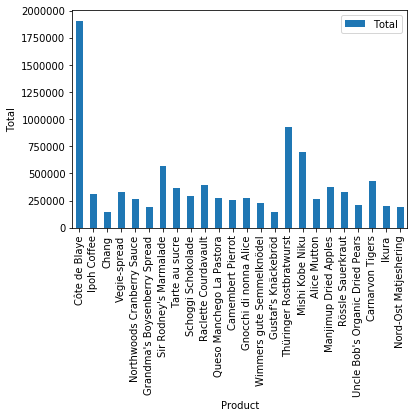

In [18]:
# Havainnollistetaan edellinen pylväskuviona
ax1 = df3.plot.bar()
ax1.set_xticklabels(df3['Product'].values.tolist())
ax1.set_xlabel('Product')
ax1.set_ylabel('Total')

In [19]:
# Suljetaan tietokantayhteys
conn.close()